## Arizona Bike Stores Monthly Sales Prediction
This model predicts future sales based on the previous month's sales and 3-months rolling average.

## Work Flow
1. Data Exploration (EDA)
2. Data Cleaning and Transformation
3. Feature Engineering
4. Pipeline, Model Tuning and Evaluation
5. Predictions

### 1. Data Exploration (EDA)

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We would use 18 months historical sales data. 
* `You could choose to use 2 or more years, depending on your industry. My suggestion would be, if your services and products are being upgraded every year like for SaaS companies, then its best to keep it at 12-18 months.`

In [2]:
# Import sales data from 2023 and 2024
sales_2024 = pd.read_csv("dataset/Fact_Sales/Sales_Data_2024.csv")
sales_2023 = pd.read_csv("dataset/Fact_Sales/Sales_Data_2023.csv")

# Concat the two years
df_sales = pd.concat([sales_2024, sales_2023])

# Convert order date to date data type
df_sales["OrderDate"] = pd.to_datetime(df_sales["OrderDate"])

# Sort sales data by date
df_sales.sort_values(by='OrderDate', ascending=True, inplace=True)
df_sales.head(3)

,OrderDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity
0,2023-01-01,SO48797,385,14335,1,1,1
1,2023-01-01,SO48802,383,24923,9,1,1
2,2023-01-01,SO48801,326,15493,1,1,1


In [3]:
# Check the min and max order date to see if all the data is present
min(df_sales.OrderDate), max(df_sales.OrderDate)

(Timestamp('2023-01-01 00:00:00'), Timestamp('2024-06-30 00:00:00'))

In [4]:
# Check data types and nulls
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53416 entries, 0 to 29371
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   OrderDate      53416 non-null  datetime64[ns]
 1   OrderNumber    53416 non-null  object        
 2   ProductKey     53416 non-null  int64         
 3   CustomerKey    53416 non-null  int64         
 4   TerritoryKey   53416 non-null  int64         
 5   OrderLineItem  53416 non-null  int64         
 6   OrderQuantity  53416 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 3.3+ MB


In [5]:
# Get the last 12 months of sales

# get the max order date and offset by 12 months
max_date = max(df_sales["OrderDate"])
date_18_months_ago = max_date - pd.DateOffset(months=18)

# filter last 12 months
df_sales = df_sales.loc[df_sales["OrderDate"] > date_18_months_ago]
df_sales.head(3)

,OrderDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity
0,2023-01-01,SO48797,385,14335,1,1,1
1,2023-01-01,SO48802,383,24923,9,1,1
2,2023-01-01,SO48801,326,15493,1,1,1


In [6]:
# Check the min and max order date again to see if we have the 12 months of sales
min(df_sales.OrderDate), max(df_sales.OrderDate)

(Timestamp('2023-01-01 00:00:00'), Timestamp('2024-06-30 00:00:00'))

In [7]:
# Import product's data to get the product price
df_products = pd.read_csv("dataset/Dim_Products.csv")
df_products.head(3)

,ProductKey,ProductSubcategoryKey,ProductSKU,ProductName,ModelName,ProductDescription,ProductColor,ProductSize,ProductStyle,ProductCost,ProductPrice
0,214,31,HL-U509-R,"Sport-100 Helmet, Red",Sport-100,"Universal fit, well-vented, lightweight , snap...",Red,0,0,13.0863,34.9900
1,215,31,HL-U509,"Sport-100 Helmet, Black",Sport-100,"Universal fit, well-vented, lightweight , snap...",Black,0,0,12.0278,33.6442
2,218,23,SO-B909-M,"Mountain Bike Socks, M",Mountain Bike Socks,Combination of natural and synthetic fibers st...,White,M,U,3.3963,9.5000


In [8]:
# Check for null values
df_products.isna().sum()

ProductKey                0
ProductSubcategoryKey     0
ProductSKU                0
ProductName               0
ModelName                 0
ProductDescription        0
ProductColor             50
ProductSize               0
ProductStyle              0
ProductCost               0
ProductPrice              0
dtype: int64

### 2. Data Cleaning and Transformation

In [9]:
# Convert order date to date datatype
df_sales["OrderDate"] = pd.to_datetime(df_sales["OrderDate"])

# Join both dataframes to get the sales
sales_products = pd.merge(df_sales, df_products, on='ProductKey', how='left')
sales_products.head(3)

,OrderDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity,ProductSubcategoryKey,ProductSKU,ProductName,ModelName,ProductDescription,ProductColor,ProductSize,ProductStyle,ProductCost,ProductPrice
0,2023-01-01,SO48797,385,14335,1,1,1,2,BK-R64Y-42,"Road-550-W Yellow, 42",Road-550-W,Same technology as all of our Road series bike...,Yellow,42,W,605.6492,1000.4375
1,2023-01-01,SO48802,383,24923,9,1,1,2,BK-R64Y-40,"Road-550-W Yellow, 40",Road-550-W,Same technology as all of our Road series bike...,Yellow,40,W,605.6492,1000.4375
2,2023-01-01,SO48801,326,15493,1,1,1,2,BK-R50R-44,"Road-650 Red, 44",Road-650,Value-priced bike with many features of our to...,Red,44,U,413.1463,699.0982


In [10]:
# Calculate sales
sales_products['Sales'] = sales_products['OrderQuantity'] * sales_products['ProductPrice']

# Select needed features
sales_data = sales_products[['OrderDate','Sales']].sort_values(by='OrderDate', ascending=True)

# Create last day of the month column to aggregate sales by month
sales_data["month_date"] = sales_data["OrderDate"] + pd.offsets.MonthEnd(0)
sales_data.head()

,OrderDate,Sales,month_date
0,2023-01-01,1000.4375,2023-01-31
1,2023-01-01,1000.4375,2023-01-31
2,2023-01-01,699.0982,2023-01-31
3,2023-01-01,2071.4196,2023-01-31
4,2023-01-01,2443.3500,2023-01-31


In [11]:
# Round total sales to 2 decimals
pd.set_option('display.float_format', lambda x: '%.2f' %x) 

# Aggregate sales to month
monthly_sales = sales_data.groupby(['month_date'])['Sales'].sum().to_frame('total_sales')
monthly_sales.head()

,total_sales
month_date,
2023-01-31,432425.74
2023-02-28,474162.79
2023-03-31,471961.88
2023-04-30,494957.42
2023-05-31,545534.74


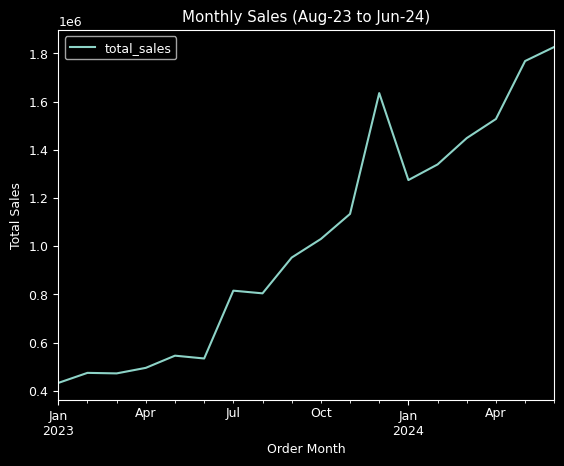

In [12]:
# Visualize the data
plt.style.use('dark_background')
plt.rcParams.update({'font.size':9})
ax = monthly_sales.plot()
ax.set(title="Monthly Sales (Aug-23 to Jun-24)", xlabel="Order Month", ylabel="Total Sales" )
plt.show()

### 3. Feature Engineering

In [13]:
# Get previous month sales feature
monthly_sales['prev_month_sales'] = monthly_sales['total_sales'].shift(1)

# Add a 3-month rolling average feature
monthly_sales['rolling_avg_3'] = monthly_sales['total_sales'].rolling(window=3).mean()

# Get previous 3 month rolling avg
monthly_sales['prev_rolling_avg_3'] = monthly_sales['rolling_avg_3'].shift(1)

# drop null values
monthly_sales.dropna(inplace=True) # first 3 months have nulls and would be dropped

monthly_sales.head()

,total_sales,prev_month_sales,rolling_avg_3,prev_rolling_avg_3
month_date,,,,
2023-04-30,494957.42,471961.88,480360.69,459516.80
2023-05-31,545534.74,494957.42,504151.35,480360.69
2023-06-30,533824.98,545534.74,524772.38,504151.35
2023-07-31,815356.47,533824.98,631572.06,524772.38
2023-08-31,804193.39,815356.47,717791.61,631572.06


### 4. Pipeline, Model Tuning and Evaluation
We would test linear and random forest regression models, to see which is better.

In [14]:
# Import needed packages
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import pickle

# split the data into features and label. 
X = monthly_sales.drop(['total_sales','rolling_avg_3'], axis=1) # We would be using the prev month sales and rolling avg
y = monthly_sales['total_sales']

# split the data train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 4a. Linear Regression

In [15]:
# Import model
from sklearn.linear_model import LinearRegression

# Define the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Polynomial feature transformation
    ('scaler', StandardScaler()),    # Feature scaling
    ('linear', LinearRegression())   # Linear regression model
])

# Define the hyperparameter grid
param_grid = {
    'poly__degree': [1, 2, 3],  # Polynomial degrees to consider
    'poly__interaction_only': [False, True],  # Whether to include only interaction features
    'poly__include_bias': [False, True]  # Whether to include a bias term
}

# Set up GridSearchCV - WE could put this in a function to reuse in random forest
def grid_search_eval():
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best hyperparameters:", best_params)

    # Predict on the test set
    global y_preds
    y_preds = grid_search.best_estimator_.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)
    rmse = np.sqrt(mse)

    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)
    
    # Get the best model
    global best_model
    best_model = grid_search.best_estimator_

# Call the function    
grid_search_eval()

# Save the model
pickle.dump(best_model, open('model/sales_prediction-linear.pkl','wb'))

Best hyperparameters: {'poly__degree': 1, 'poly__include_bias': False, 'poly__interaction_only': False}
Mean Squared Error: 73906732564.75136
Mean Absolute Error: 208580.31291241487
Root Mean Squared Error: 271857.9271692318


In [16]:
# Compare actual sales and predicted sales
result = pd.DataFrame(X_test)
result['Predicted_Sales'] = y_preds
result['Actual_Sales'] = y_test
result['diff'] = abs(result['Predicted_Sales'] - result['Actual_Sales']) 
result.sort_values(by='month_date', ascending=True, inplace=True)
result

,prev_month_sales,prev_rolling_avg_3,Predicted_Sales,Actual_Sales,diff
month_date,,,,,
2023-04-30,471961.88,459516.80,590755.73,494957.42,95798.32
2024-01-31,1635308.80,1266347.63,1729249.01,1274378.67,454870.35
2024-03-31,1339241.29,1416309.59,1523668.40,1448596.12,75072.27


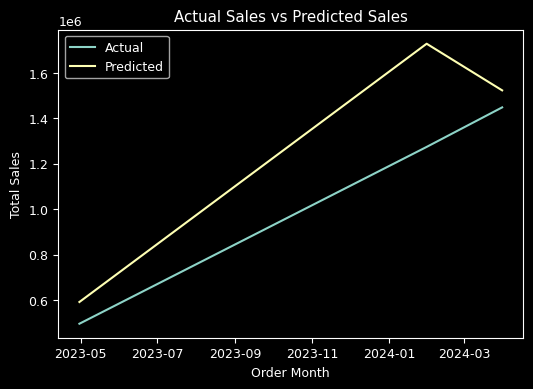

In [17]:
# visualize the result
plt.figure(figsize=(6,4))
plt.plot(result['Actual_Sales'], label='Actual')
plt.plot(result['Predicted_Sales'], label='Predicted')
plt.title("Actual Sales vs Predicted Sales")
plt.ylabel("Total Sales")
plt.xlabel("Order Month")
plt.legend()
plt.show()

#### 4b. Random Forest Regressor

In [18]:
from sklearn.ensemble import RandomForestRegressor

# Create Pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

# define parameters
param_grid = {
    'regressor__n_estimators':np.arange(10,300,20), # no of treesin the forest
    'regressor__max_depth':[None, 10, 20, 30], # depth of the trees, maybe branches
    'regressor__min_samples_split':[2, 5, 10], # for internal node
    'regressor__min_samples_leaf':[1, 2, 4] # for leaf node
   # 'regressor__max_features':['auto', 'sqrt', 'log2'] # features to consider when splitting
}

# Call the function
grid_search_eval()

# Save the model
pickle.dump(best_model, open('model/sales_prediction-randomforest.pkl','wb'))

Best hyperparameters: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 10}
Mean Squared Error: 41828470232.94723
Mean Absolute Error: 191666.95457896823
Root Mean Squared Error: 204520.09738152198


In [19]:
# Compare actual sales and predicted sales
result = pd.DataFrame(X_test)
result['Predicted_Sales'] = y_preds
result['Actual_Sales'] = y_test
result['diff'] = abs(result['Predicted_Sales'] - result['Actual_Sales']) 
result.sort_values(by='month_date', ascending=True, inplace=True)
result

,prev_month_sales,prev_rolling_avg_3,Predicted_Sales,Actual_Sales,diff
month_date,,,,,
2023-04-30,471961.88,459516.80,644563.39,494957.42,149605.98
2024-01-31,1635308.80,1266347.63,1566521.24,1274378.67,292142.57
2024-03-31,1339241.29,1416309.59,1581848.44,1448596.12,133252.31


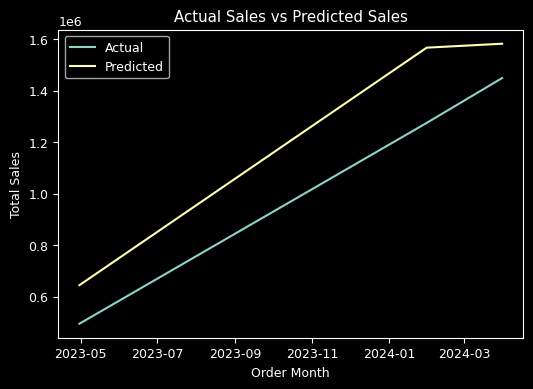

In [20]:
# Visualize the result
plt.figure(figsize=(6,4))
plt.plot(result['Actual_Sales'], label='Actual')
plt.plot(result['Predicted_Sales'], label='Predicted')
plt.title("Actual Sales vs Predicted Sales")
plt.ylabel("Total Sales")
plt.xlabel("Order Month")
plt.legend()
plt.show()

We can see that the random forest regression model produced slightly better results. 
We would use the random forest model to predict next month sales.

### 5. Prediction - make prediction for next month

We would use the last month sales and average sales for the last 3months to predict the next month sales

In [21]:
# Get the data for the last month sales
total_sales = monthly_sales.iloc[-1]['total_sales']
month_3_rolling_avg = monthly_sales.iloc[-1]['rolling_avg_3']
next_month = monthly_sales.index[-1]+ pd.DateOffset(months=1)

# Display in a dataframe for clarity
data = pd.DataFrame({"prev_month_sales": [total_sales], 
                              "prev_rolling_avg_3":[month_3_rolling_avg]}, 
                             index = [next_month] )
data

,prev_month_sales,prev_rolling_avg_3
2024-07-30,1826987.14,1707744.45


In [24]:
# Predict the sales for the next month (July 2024)
linear_model = pickle.load(open("model/sales_prediction-randomforest.pkl","rb"))
next_month_prediction = linear_model.predict(data)

# put it in a dataframe
prediction_df = pd.DataFrame()
prediction_df['total_sales'] = [next_month_prediction[0]]
prediction_df['month_date'] = [monthly_sales.index[-1] + pd.DateOffset(months=1)]
prediction_df.set_index('month_date', inplace=True)
prediction_df

,total_sales
month_date,
2024-07-30,1628533.08


`We could run predictions for future months, using a for loop to calculate the 3 months rolling average for the predicted month and then predict the month after and so on.`

In [25]:
# We would save the monthly sale df to use for testing in production
monthly_sales.to_csv("monthly_sales.csv")